In [2]:
:dep anyhow = "1.0.66"
:dep opencv = "0.70.0"
:dep image = "0.23"
:dep evcxr_image = "1.1.0"
:dep ndarray = "0.15.6"
:dep nalgebra = "0.31.2"
:dep cv-convert = { version = "0.21.2", features=["opencv_0-70", "image_0-23", "nalgebra_0-31", "ndarray_0-15"] }

use std::fs;
use std::path::{Path};
use anyhow::{anyhow, Result, Error};
use opencv::prelude::*;
use cv_convert::{FromCv, IntoCv, TryFromCv, TryIntoCv};
use image::{ImageBuffer, RgbImage, Rgb};
use evcxr_image::ImageDisplay;
use ndarray::prelude::*;

#[macro_use]
extern crate nalgebra as na;

fn to_8u_img_est(img: &Mat) -> Result<Mat> {
    let mut min: f64 = Default::default();
    let min_containter = Some(&mut min);
    let mut max: f64 = Default::default();
    let max_containter = Some(&mut max);
    opencv::core::min_max_loc(
        &img,
        min_containter,
        max_containter,
        None,
        None,
        &opencv::core::no_array()
    );
    let mut img_dst: Mat = Default::default();
    match img.channels() {
        3 => {
            img.convert_to(&mut img_dst, opencv::core::CV_8UC3, 255.0 / (&max - &min), -255.0 * (&min)/(&max - &min));
        },
        _ => {
            img.convert_to(&mut img_dst, opencv::core::CV_8UC1, 255.0 / (&max - &min), -255.0 * (&min)/(&max - &min));
        }
    }
    Ok(img_dst)
}

fn opencv_imshow(img: &Mat) {
    let img_rgb = RgbImage::new(img.cols() as u32, img.rows() as u32);
    let channels: u32 = img.channels() as u32;
    let mut data: Vec<u8> = Default::default();
    if img.depth() != opencv::core::CV_8U {
        let img_dst = to_8u_img_est(&img).unwrap();
        data = img_dst.data_bytes().unwrap().to_vec();
    } else {
        data = img.data_bytes().unwrap().to_vec();
    }
    image::ImageBuffer::from_fn(img_rgb.width(), img_rgb.height(), | x, y | {
        let yi = y * img_rgb.width();
        let i: usize = ((x + yi) * channels) as usize;
        match channels {
            3 => {
                let b = data[i];
                let g = data[i + 1];
                let r = data[i + 2];
                image::Rgb([r, g, b])
            },
            _ => {
                let b = data[i];
                image::Rgb([b, b, b])
            }
        }
    }).evcxr_display()
}

let image_dir = "opencv_samples/images";

# Basic Template Matching

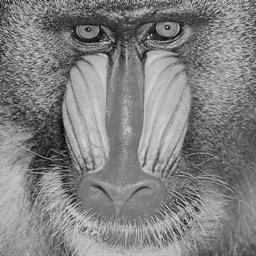

In [3]:
let image_path = Path::new(image_dir).join("Mandrill.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
opencv_imshow(&img)

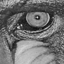

In [4]:
// let mut img_roi: opencv::core::Mat = Mat::roi(
//     &img,
//     opencv::core::Rect::new(128, 64, 64, 64))?;
// same result as img_roi
// let img_crop: opencv::core::Mat = Mat::rowscols(
//     &img,
//     &opencv::core::Range::new(64, 128)?, // rowr_ange
//     &opencv::core::Range::new(128, 192)?)?; //col_range
let img_crop: opencv::core::Mat = Mat::rowscols( // for mandrill.bmp
    &img,
    &opencv::core::Range::new(10, 74)?, // rowr_ange
    &opencv::core::Range::new(130, 194)?)?; //col_range
let mut img_template: opencv::core::Mat = Mat::new_rows_cols_with_default(64, 64, opencv::core::CV_8UC1, opencv::core::Scalar::all(0.))?;
img_crop.copy_to(&mut img_template)?;
opencv_imshow(&img_template)

In [5]:
let resource_size: opencv::core::Size = opencv::core::Size::new(img.cols() - img_template.cols(), img.rows() - img_template.rows());
println!("{:?}", &resource_size);

Size_ { width: 192, height: 192 }


# SSD(Sum of Squared Difference)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: 0, minLoc: Point_ { x: 130, y: 10 }
maxVal: 25330108, maxLoc: Point_ { x: 41, y: 98 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


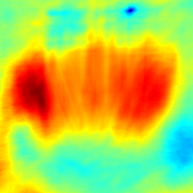

In [6]:
let mut ssd_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut ssd_result,
    opencv::imgproc::TM_SQDIFF,
    &opencv::core::no_array()
);
println!("{:?}", &ssd_result);
let mut ssd_result_min: f64 = Default::default();
let ssd_result_min_containter = Some(&mut ssd_result_min);
let mut ssd_result_max: f64 = Default::default();
let ssd_result_max_containter = Some(&mut ssd_result_max);
let mut ssd_result_min_loc: opencv::core::Point = Default::default();
let ssd_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ssd_result_min_loc);
let mut ssd_result_max_loc: opencv::core::Point = Default::default();
let ssd_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ssd_result_max_loc);
opencv::core::min_max_loc(
    &ssd_result,
    ssd_result_min_containter,
    ssd_result_max_containter,
    ssd_result_min_loc_containter,
    ssd_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &ssd_result_min, &ssd_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &ssd_result_max, &ssd_result_max_loc);
ssd_result = (&ssd_result / &ssd_result_max).into_result()?.to_mat()?;
let mut ssd_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in ssd_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ssd_result_clamped_vec2.len() < (p.y + 1) as usize {
        ssd_result_clamped_vec2.push(vec![]);
    }
    ssd_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut ssd_result_clamped_mat: Mat = Mat::from_slice_2d(&ssd_result_clamped_vec2)?;

let mut ssd_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &ssd_result_clamped_mat,
    &mut ssd_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ssd_result_color_map);

opencv_imshow(&ssd_result_color_map)

If we apply abs calculation to clamped result, that make more accurate result.

Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


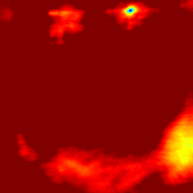

In [7]:
let mut ssd_result_clamped_vec2_f32: Vec<Vec<f32>> = Default::default();
for (p, v) in ssd_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ssd_result_clamped_vec2_f32.len() < (p.y + 1) as usize {
        ssd_result_clamped_vec2_f32.push(vec![]);
    }
    ssd_result_clamped_vec2_f32[p.y as usize].push(new_v.clamp(0., 255.));
}
let mut ssd_result_clamped_mat_f32: Mat = Mat::from_slice_2d(&ssd_result_clamped_vec2_f32)?;

let mut img_ssd_result_f32_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&ssd_result_clamped_mat_f32, &mut img_ssd_result_f32_abs, 2., 0.);

let mut ssd_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &img_ssd_result_f32_abs,
    &mut ssd_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ssd_result_color_map);

opencv_imshow(&ssd_result_color_map)

# SAD(Sum of Absolute Difference)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 4, elem_size1: 4, total: 36864, is_continuous: true, is_submatrix: false }
minVal: 0, minLoc: Point_ { x: 130, y: 10 }
maxVal: 270213, maxLoc: Point_ { x: 40, y: 91 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 3, elem_size1: 1, total: 36864, is_continuous: true, is_submatrix: false }


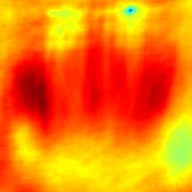

In [8]:
let mut img_f32: Mat = Default::default();
let mut img_template_f32: Mat = Default::default();
img.convert_to(&mut img_f32, opencv::core::CV_32FC1, 1., 0.);
img_template.convert_to(&mut img_template_f32, opencv::core::CV_32FC1, 1., 0.);

let mut sad_result: Mat = Mat::zeros_size(resource_size, opencv::core::CV_32FC1).unwrap().to_mat().unwrap();
    for h in 0..resource_size.height {
        for w in 0..resource_size.width {
            let mut diff: f32 = 0.0;
            let ch_end = h + img_template_f32.rows();
            let cw_end = w + img_template_f32.cols();
            for (i, ch) in (h..ch_end).enumerate() {
                for (j, cw) in (w..cw_end).enumerate() {
                    // if do sum(diff**2), it same return as SSD result.
                    diff += (img_template_f32.at_2d(i as i32, j as i32).unwrap_or(&0.0_f32) - img_f32.at_2d(ch, cw).unwrap_or(&0.0_f32)).abs();
                }
            }
            let mut target = sad_result.at_2d_mut::<f32>(h, w).unwrap();
            *target = diff;
        }
    }
println!("{:?}", &sad_result);
let mut sad_result_min: f64 = Default::default();
let sad_result_min_containter = Some(&mut sad_result_min);
let mut sad_result_max: f64 = Default::default();
let sad_result_max_containter = Some(&mut sad_result_max);
let mut sad_result_min_loc: opencv::core::Point = Default::default();
let sad_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut sad_result_min_loc);
let mut sad_result_max_loc: opencv::core::Point = Default::default();
let sad_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut sad_result_max_loc);
opencv::core::min_max_loc(
    &sad_result,
    sad_result_min_containter,
    sad_result_max_containter,
    sad_result_min_loc_containter,
    sad_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &sad_result_min, &sad_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &sad_result_max, &sad_result_max_loc);
sad_result = (&sad_result / &sad_result_max).into_result()?.to_mat()?;
let mut sad_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in sad_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if sad_result_clamped_vec2.len() < (p.y + 1) as usize {
        sad_result_clamped_vec2.push(vec![]);
    }
    sad_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut sad_result_clamped_mat: Mat = Mat::from_slice_2d(&sad_result_clamped_vec2)?;

let mut sad_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &sad_result_clamped_mat,
    &mut sad_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &sad_result_color_map);

opencv_imshow(&sad_result_color_map)

Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 192, height: 192 }, rows: 192, cols: 192, elem_size: 3, elem_size1: 1, total: 36864, is_continuous: true, is_submatrix: false }


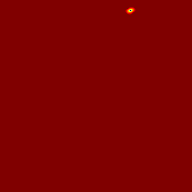

In [9]:
let mut img_sad_result_f32_abs: Mat = Default::default();
opencv::core::convert_scale_abs(&sad_result_clamped_mat, &mut img_sad_result_f32_abs, 2., 0.);

let mut sad_result_color_map_abs: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &img_sad_result_f32_abs,
    &mut sad_result_color_map_abs,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &sad_result_color_map_abs);

opencv_imshow(&sad_result_color_map_abs)

# NCC

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: 0.8007628917694092, minLoc: Point_ { x: 25, y: 102 }
maxVal: 1, maxLoc: Point_ { x: 130, y: 10 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


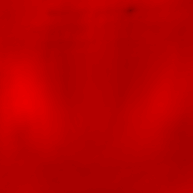

In [10]:
let mut ncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut ncc_result,
    opencv::imgproc::TM_CCORR_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &ncc_result);
let mut ncc_result_min: f64 = Default::default();
let ncc_result_min_containter = Some(&mut ncc_result_min);
let mut ncc_result_max: f64 = Default::default();
let ncc_result_max_containter = Some(&mut ncc_result_max);
let mut ncc_result_min_loc: opencv::core::Point = Default::default();
let ncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ncc_result_min_loc);
let mut ncc_result_max_loc: opencv::core::Point = Default::default();
let ncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut ncc_result_max_loc);
opencv::core::min_max_loc(
    &ncc_result,
    ncc_result_min_containter,
    ncc_result_max_containter,
    ncc_result_min_loc_containter,
    ncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &ncc_result_min, &ncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &ncc_result_max, &ncc_result_max_loc);
// ncc_result = (&ncc_result / &ncc_result_max).into_result()?.to_mat()?;
ncc_result = ((&ncc_result + &Mat::new_rows_cols_with_default(
    ncc_result.cols(), ncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut ncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in ncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if ncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        ncc_result_clamped_vec2.push(vec![]);
    }
    ncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut ncc_result_clamped_mat: Mat = Mat::from_slice_2d(&ncc_result_clamped_vec2)?;

let mut ncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &ncc_result_clamped_mat,
    &mut ncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &ncc_result_color_map);

opencv_imshow(&ncc_result_color_map)

# ZNCC

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 4, elem_size1: 4, total: 37249, is_continuous: true, is_submatrix: false }
minVal: -0.3732060492038727, minLoc: Point_ { x: 192, y: 192 }
maxVal: 1, maxLoc: Point_ { x: 130, y: 10 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 193, height: 193 }, rows: 193, cols: 193, elem_size: 3, elem_size1: 1, total: 37249, is_continuous: true, is_submatrix: false }


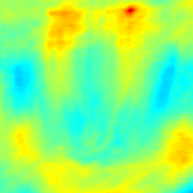

In [11]:
let mut zncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut zncc_result,
    opencv::imgproc::TM_CCOEFF_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &zncc_result);
let mut zncc_result_min: f64 = Default::default();
let zncc_result_min_containter = Some(&mut zncc_result_min);
let mut zncc_result_max: f64 = Default::default();
let zncc_result_max_containter = Some(&mut zncc_result_max);
let mut zncc_result_min_loc: opencv::core::Point = Default::default();
let zncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_min_loc);
let mut zncc_result_max_loc: opencv::core::Point = Default::default();
let zncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_max_loc);
opencv::core::min_max_loc(
    &zncc_result,
    zncc_result_min_containter,
    zncc_result_max_containter,
    zncc_result_min_loc_containter,
    zncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &zncc_result_min, &zncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &zncc_result_max, &zncc_result_max_loc);
// zncc_result = (&zncc_result / &zncc_result_max).into_result()?.to_mat()?;
zncc_result = ((&zncc_result + &Mat::new_rows_cols_with_default(
    zncc_result.cols(), zncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut zncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in zncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if zncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        zncc_result_clamped_vec2.push(vec![]);
    }
    zncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut zncc_result_clamped_mat: Mat = Mat::from_slice_2d(&zncc_result_clamped_vec2)?;

let mut zncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &zncc_result_clamped_mat,
    &mut zncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &zncc_result_color_map);

opencv_imshow(&zncc_result_color_map)

# Template Matching for Rotated Image

(256, 256)


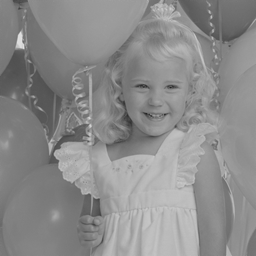

In [12]:
let image_path = Path::new(image_dir).join("Balloon.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
println!("({}, {})", img.cols(), img.rows());
opencv_imshow(&img)

(128, 128)


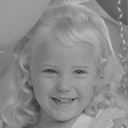

In [13]:
let mut img_roi: opencv::core::Mat = Mat::roi(
    &img,
    opencv::core::Rect::new(92, 15, 128, 128))?;
// same result as img_roi
// let img_crop: opencv::core::Mat = Mat::rowscols(
//     &img,
//     &opencv::core::Range::new(64, 128)?, // rowr_ange
//     &opencv::core::Range::new(128, 192)?)?; //col_range
let mut img_template: opencv::core::Mat = Mat::new_rows_cols_with_default(64, 64, opencv::core::CV_8UC1, opencv::core::Scalar::all(0.))?;
img_roi.copy_to(&mut img_template)?;
println!("({}, {})", img_template.cols(), img_template.rows());
opencv_imshow(&img_template)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 129, height: 129 }, rows: 129, cols: 129, elem_size: 4, elem_size1: 4, total: 16641, is_continuous: true, is_submatrix: false }
minVal: -0.4446907341480255, minLoc: Point_ { x: 128, y: 120 }
maxVal: 1, maxLoc: Point_ { x: 92, y: 15 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 129, height: 129 }, rows: 129, cols: 129, elem_size: 3, elem_size1: 1, total: 16641, is_continuous: true, is_submatrix: false }


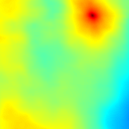

In [14]:
let mut zncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img,
    &img_template,
    &mut zncc_result,
    opencv::imgproc::TM_CCOEFF_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &zncc_result);
let mut zncc_result_min: f64 = Default::default();
let zncc_result_min_containter = Some(&mut zncc_result_min);
let mut zncc_result_max: f64 = Default::default();
let zncc_result_max_containter = Some(&mut zncc_result_max);
let mut zncc_result_min_loc: opencv::core::Point = Default::default();
let zncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_min_loc);
let mut zncc_result_max_loc: opencv::core::Point = Default::default();
let zncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_max_loc);
opencv::core::min_max_loc(
    &zncc_result,
    zncc_result_min_containter,
    zncc_result_max_containter,
    zncc_result_min_loc_containter,
    zncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &zncc_result_min, &zncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &zncc_result_max, &zncc_result_max_loc);
// zncc_result = (&zncc_result / &zncc_result_max).into_result()?.to_mat()?;
zncc_result = ((&zncc_result + &Mat::new_rows_cols_with_default(
    zncc_result.cols(), zncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut zncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in zncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if zncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        zncc_result_clamped_vec2.push(vec![]);
    }
    zncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut zncc_result_clamped_mat: Mat = Mat::from_slice_2d(&zncc_result_clamped_vec2)?;

let mut zncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &zncc_result_clamped_mat,
    &mut zncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &zncc_result_color_map);

opencv_imshow(&zncc_result_color_map)

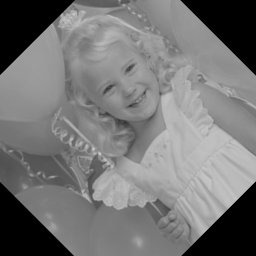

In [15]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.),
    45.0,
    1.0
).unwrap();
let mut img_rotated: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_rotated,
    &trans,
    opencv::core::Size::new(img.cols(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BorderTypes::BORDER_CONSTANT as i32,
    opencv::core::Scalar::all(-1.)
);
opencv_imshow(&img_rotated)

Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 129, height: 129 }, rows: 129, cols: 129, elem_size: 4, elem_size1: 4, total: 16641, is_continuous: true, is_submatrix: false }
minVal: -0.1970095932483673, minLoc: Point_ { x: 5, y: 14 }
maxVal: 0.46474164724349976, maxLoc: Point_ { x: 102, y: 17 }
Mat { type: "CV_8UC3", flags: 1124024336, channels: 3, depth: "CV_8U", dims: 2, size: Size_ { width: 129, height: 129 }, rows: 129, cols: 129, elem_size: 3, elem_size1: 1, total: 16641, is_continuous: true, is_submatrix: false }


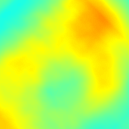

In [16]:
let mut zncc_result: Mat = Default::default();
opencv::imgproc::match_template(
    &img_rotated,
    &img_template,
    &mut zncc_result,
    opencv::imgproc::TM_CCOEFF_NORMED,
    &opencv::core::no_array()
);
println!("{:?}", &zncc_result);
let mut zncc_result_min: f64 = Default::default();
let zncc_result_min_containter = Some(&mut zncc_result_min);
let mut zncc_result_max: f64 = Default::default();
let zncc_result_max_containter = Some(&mut zncc_result_max);
let mut zncc_result_min_loc: opencv::core::Point = Default::default();
let zncc_result_min_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_min_loc);
let mut zncc_result_max_loc: opencv::core::Point = Default::default();
let zncc_result_max_loc_containter: Option<&mut opencv::core::Point> = Some(&mut zncc_result_max_loc);
opencv::core::min_max_loc(
    &zncc_result,
    zncc_result_min_containter,
    zncc_result_max_containter,
    zncc_result_min_loc_containter,
    zncc_result_max_loc_containter,
    &opencv::core::no_array()
);
println!("minVal: {:}, minLoc: {:?}", &zncc_result_min, &zncc_result_min_loc);
println!("maxVal: {:}, maxLoc: {:?}", &zncc_result_max, &zncc_result_max_loc);
// zncc_result = (&zncc_result / &zncc_result_max).into_result()?.to_mat()?;
zncc_result = ((&zncc_result + &Mat::new_rows_cols_with_default(
    zncc_result.cols(), zncc_result.rows(), opencv::core::CV_32FC1,
    opencv::core::Scalar::new(1.0, 1.0, 1.0, 1.0)).unwrap())/2.0).into_result()?.to_mat()?;
let mut zncc_result_clamped_vec2: Vec<Vec<u8>> = Default::default();
for (p, v) in zncc_result.iter::<f32>()? {
    let new_v: f32 = v * 255.;
    if zncc_result_clamped_vec2.len() < (p.y + 1) as usize {
        zncc_result_clamped_vec2.push(vec![]);
    }
    zncc_result_clamped_vec2[p.y as usize].push(new_v.clamp(0., 255.) as u8);
}
let mut zncc_result_clamped_mat: Mat = Mat::from_slice_2d(&zncc_result_clamped_vec2)?;

let mut zncc_result_color_map: Mat = Default::default();
opencv::imgproc::apply_color_map(
    &zncc_result_clamped_mat,
    &mut zncc_result_color_map,
    opencv::imgproc::ColormapTypes::COLORMAP_JET as i32
);
println!("{:?}", &zncc_result_color_map);

opencv_imshow(&zncc_result_color_map)

# 2D FFT

Mat { type: "CV_8UC1", flags: 1124024320, channels: 1, depth: "CV_8U", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 1, elem_size1: 1, total: 65536, is_continuous: true, is_submatrix: false }


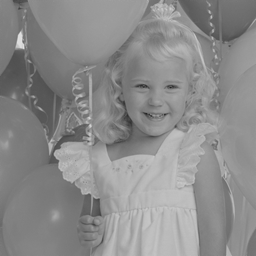

In [17]:
let image_path = Path::new(image_dir).join("Balloon.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
println!("{:?}", &img);
let mut img_f32: Mat = Default::default();
img.convert_to(&mut img_f32, opencv::core::CV_32FC1, 1., 0.);
opencv_imshow(&img)

DFT Result:
Mat { type: "CV_32FC2", flags: 1124024333, channels: 2, depth: "CV_32F", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 8, elem_size1: 4, total: 65536, is_continuous: true, is_submatrix: false }

Split DFT Result to vector (VectorOfMat):
[Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 4, elem_size1: 4, total: 65536, is_continuous: true, is_submatrix: false }, Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 4, elem_size1: 4, total: 65536, is_continuous: true, is_submatrix: false }]

Compute the magnitude and switch to log scale:
Mat { type: "CV_32FC1", flags: 1124024325, channels: 1, depth: "CV_32F", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 4, elem_size1: 4, total: 65536, is_continuous

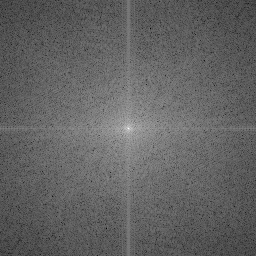

In [18]:
println!("DFT Result:");
let mut dft_img: Mat = Default::default();
opencv::core::dft(
    &img_f32,
    &mut dft_img,
    opencv::core::DFT_COMPLEX_OUTPUT,
    0
);
println!("{:?}", &dft_img);
println!("");
println!("Split DFT Result to vector (VectorOfMat):");
let mut f_split: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
opencv::core::split(&dft_img, &mut f_split);
println!("{:?}", &f_split);
println!("");
println!("Compute the magnitude and switch to log scale:");
let mut magnitude_dst: Mat = Default::default();
opencv::core::magnitude(&f_split.get(0).unwrap(), &f_split.get(1).unwrap(), &mut magnitude_dst);
magnitude_dst = (magnitude_dst + &opencv::core::Scalar::all(1.)).into_result().unwrap().to_mat().unwrap();
let mut magnitude_log_dst: Mat = Default::default();
opencv::core::log(&magnitude_dst, &mut magnitude_log_dst);
println!("{:?}", &magnitude_log_dst);

let cx: i32 = magnitude_log_dst.cols() / 2;
let cy: i32 = magnitude_log_dst.rows() / 2;

let mut q0: Mat = Mat::roi(&magnitude_log_dst, opencv::core::Rect::new(0, 0, cx, cy))?;
let mut q1: Mat = Mat::roi(&magnitude_log_dst, opencv::core::Rect::new(cx, 0, cx, cy))?;
let mut q2: Mat = Mat::roi(&magnitude_log_dst, opencv::core::Rect::new(0, cy, cx, cy))?;
let mut q3: Mat = Mat::roi(&magnitude_log_dst, opencv::core::Rect::new(cx, cy, cx, cy))?;

let mut temp: Mat = Default::default();
q0.copy_to(&mut temp);
q3.copy_to(&mut q0);
temp.copy_to(&mut q3);

q1.copy_to(&mut temp);
q2.copy_to(&mut q1);
temp.copy_to(&mut q2);

let mut result: Mat = Default::default();
opencv::core::normalize(&magnitude_log_dst, &mut result,
    0., 1., opencv::core::NORM_MINMAX, -1, &opencv::core::no_array());

// Mapping for imshow (merged to opencv_imshow)
let mut min: f64 = Default::default();
let min_containter = Some(&mut min);
let mut max: f64 = Default::default();
let max_containter = Some(&mut max);
opencv::core::min_max_loc(
    &result,
    min_containter,
    max_containter,
    None,
    None,
    &opencv::core::no_array()
);
println!("{}, {}", &min, &max);
let mut result_dst: Mat = Default::default();
result.convert_to(&mut result_dst, opencv::core::CV_8UC1, 255.0 / (&max - &min), -255.0 * (&min)/(&max - &min));
opencv_imshow(&result_dst)

## Reconstruct Image

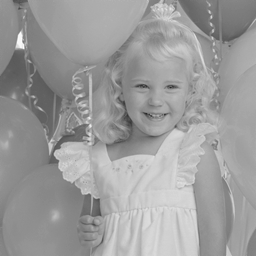

In [19]:
let mut img_reconstructed: Mat = Default::default();
opencv::core::dft(
    &dft_img,
    &mut img_reconstructed,
    opencv::core::DFT_INVERSE | opencv::core::DFT_COMPLEX_INPUT,
    0
);
opencv_imshow(&img_reconstructed);

## High/Low Pass Filter

DFT Result:
Mat { type: "CV_32FC2", flags: 1124024333, channels: 2, depth: "CV_32F", dims: 2, size: Size_ { width: 256, height: 256 }, rows: 256, cols: 256, elem_size: 8, elem_size1: 4, total: 65536, is_continuous: true, is_submatrix: false }


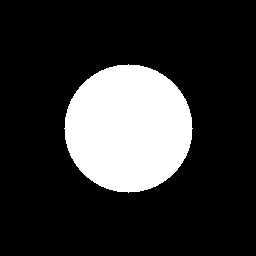

In [20]:
println!("DFT Result:");
let mut dft_img_orig: Mat = Default::default();
opencv::core::dft(
    &img_f32,
    &mut dft_img_orig,
    opencv::core::DFT_COMPLEX_OUTPUT,
    0
);
println!("{:?}", &dft_img_orig);

fn crop_n_rearrange(target: &mut Mat) {
    let cx: i32 = target.cols() / 2;
    let cy: i32 = target.rows() / 2;

    let mut q0: Mat = Mat::roi(&target, opencv::core::Rect::new(0, 0, cx, cy)).unwrap();
    let mut q1: Mat = Mat::roi(&target, opencv::core::Rect::new(cx, 0, cx, cy)).unwrap();
    let mut q2: Mat = Mat::roi(&target, opencv::core::Rect::new(0, cy, cx, cy)).unwrap();
    let mut q3: Mat = Mat::roi(&target, opencv::core::Rect::new(cx, cy, cx, cy)).unwrap();

    let mut temp: Mat = Default::default();
    q0.copy_to(&mut temp);
    q3.copy_to(&mut q0);
    temp.copy_to(&mut q3);

    q1.copy_to(&mut temp);
    q2.copy_to(&mut q1);
    temp.copy_to(&mut q2);
}

let mut filter: Mat = Mat::new_rows_cols_with_default(
    img.rows(), img.cols(), opencv::core::CV_32FC2, opencv::core::Scalar::all(0.)
).unwrap();
opencv::imgproc::circle(&mut filter, opencv::core::Point::new(img.cols() / 2, img.rows() / 2), 64,
    opencv::core::Scalar::all(1.),
    opencv::imgproc::FILLED, opencv::imgproc::LINE_8, 0);
opencv_imshow(&filter)

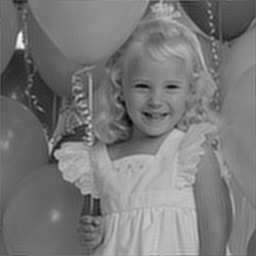

In [21]:
let mut dft_img_1: Mat = dft_img_orig.clone().to_owned();
let mut img_filtered_1: Mat = Default::default();
crop_n_rearrange(&mut dft_img_1);
opencv::core::mul_spectrums(&dft_img_1, &filter, &mut img_filtered_1, 0, false);
crop_n_rearrange(&mut img_filtered_1);

let mut img_idft_dst: Mat = Default::default();
opencv::core::idft(
    &img_filtered_1,
    &mut img_idft_dst,
    opencv::core::DFT_COMPLEX_INPUT,
    0
);
opencv_imshow(&img_idft_dst);

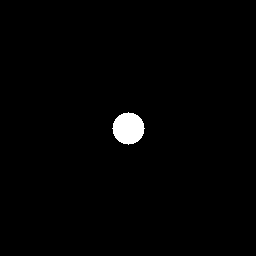

In [22]:
let mut filter: Mat = Mat::new_rows_cols_with_default(
    img.rows(), img.cols(), opencv::core::CV_32FC2, opencv::core::Scalar::all(0.)
).unwrap();
opencv::imgproc::circle(&mut filter, opencv::core::Point::new(img.cols() / 2, img.rows() / 2), 16,
    opencv::core::Scalar::all(1.),
    opencv::imgproc::FILLED, opencv::imgproc::LINE_8, 0);
opencv_imshow(&filter);

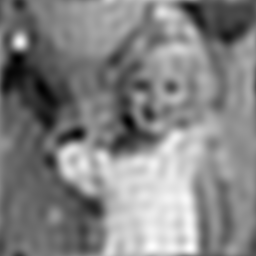

In [23]:
let mut dft_img_2: Mat = dft_img_orig.clone().to_owned();
let mut img_filtered_2: Mat = Default::default();
crop_n_rearrange(&mut dft_img_2);
opencv::core::mul_spectrums(&dft_img_2, &filter, &mut img_filtered_2, 0, false);
crop_n_rearrange(&mut img_filtered_2);

let mut img_idft_dst: Mat = Default::default();
opencv::core::idft(
    &img_filtered_2,
    &mut img_idft_dst,
    opencv::core::DFT_COMPLEX_INPUT,
    0
);
opencv_imshow(&img_idft_dst);

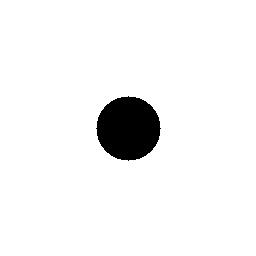

In [24]:
let mut filter: Mat = Mat::new_rows_cols_with_default(
    img.rows(), img.cols(), opencv::core::CV_32FC2, opencv::core::Scalar::all(1.)
).unwrap();
opencv::imgproc::circle(&mut filter, opencv::core::Point::new(img.cols() / 2, img.rows() / 2), 32,
    opencv::core::Scalar::all(0.),
    opencv::imgproc::FILLED, opencv::imgproc::LINE_8, 0);
opencv_imshow(&filter);

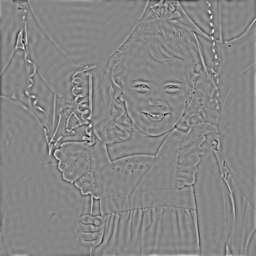

In [25]:
let mut dft_img_3: Mat = dft_img_orig.clone().to_owned();
let mut img_filtered_3: Mat = Default::default();
crop_n_rearrange(&mut dft_img_3);
opencv::core::mul_spectrums(&dft_img_3, &filter, &mut img_filtered_3, 0, false);
crop_n_rearrange(&mut img_filtered_3);

let mut img_idft_dst: Mat = Default::default();
opencv::core::idft(
    &img_filtered_3,
    &mut img_idft_dst,
    opencv::core::DFT_COMPLEX_INPUT,
    0
);
opencv_imshow(&img_idft_dst);

In [26]:
let mut dft_img_4: Mat = Default::default();
opencv::core::dft(
    &img_f32,
    &mut dft_img_4,
    opencv::core::DFT_COMPLEX_OUTPUT,
    0
);
let mut dft_img_4_abs: Mat = Default::default();
// opencv::core::convert_scale_abs(&dft_img_4, &mut dft_img_4_abs, 1., 0.);
// let mut dft_img_4_abs_f32: Mat = Default::default();
// dft_img_4_abs.convert_to(&mut dft_img_4_abs_f32, opencv::core::CV_32FC1, 1., 0.);
// let mut dft_img_div_abs: Mat = Default::default();
// opencv::imgproc::div_spectrums(&dft_img_4, &dft_img_4_abs_f32, &mut dft_img_div_abs, 0, false);
// println!("{:?}", &dft_img_div_abs);
// opencv_imshow(&dft_img_div_abs)

# Phase Only Correlation

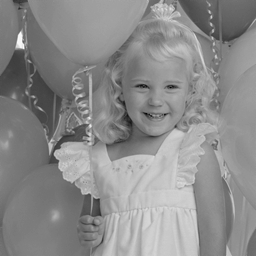

In [27]:
let image_path = Path::new(image_dir).join("Balloon.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
let mut img_f32: Mat = Default::default();
img.convert_to(&mut img_f32, opencv::core::CV_32FC1, 1., 0.);
opencv_imshow(&img_f32)

We crop the original image at x:84, y:20 and set the size to 128*128.
And copy the cropped image to x:0, y:0 position of same size(256*256) of original Mat.


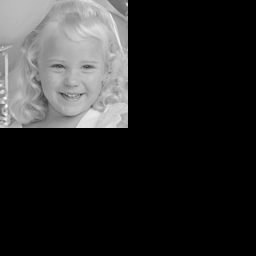

In [28]:
let mut template: Mat = Mat::new_rows_cols_with_default(
    img_f32.rows(),
    img_f32.cols(),
    opencv::core::CV_32FC1,
    opencv::core::Scalar::all(0.)
).unwrap();
let mut template_roi: Mat = opencv::core::Mat::roi(&mut template,
    opencv::core::Rect::new(0, 0, 128, 128)
).unwrap();
let img_crop: opencv::core::Mat = Mat::rowscols(
    &img_f32,
    &opencv::core::Range::new(20, 148)?, 
    &opencv::core::Range::new(84, 212)?)?;
img_crop.copy_to(&mut template_roi).unwrap();
println!("We crop the original image at x:84, y:20 and set the size to 128*128.");
println!("And copy the cropped image to x:0, y:0 position of same size(256*256) of original Mat.");
opencv_imshow(&template)

phase_shift: Point_ { x: -83.95418201305051, y: -20.019660312123193 }, response: 0.43740999628789723
We set the crop area x:84, y:20 in previous cell. see the phase_shift result.


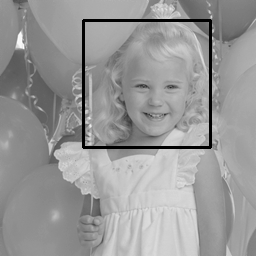

In [29]:
let mut response: f64 = 0.;
let phase_shift: opencv::core::Point2d = opencv::imgproc::phase_correlate(
    &img_f32,
    &template,
    &opencv::core::no_array(),
    &mut response
).unwrap();
println!("phase_shift: {:?}, response: {}", &phase_shift, &response);
println!("We set the crop area x:84, y:20 in previous cell. see the phase_shift result.");
opencv::imgproc::rectangle(
    &mut img_f32,
    opencv::core::Rect::new(
        phase_shift.x.abs() as i32,
        phase_shift.y.abs() as i32,
        128,
        128
    ),
    opencv::core::Scalar::new(0., 255., 0., 100.),
    2,
    opencv::imgproc::LINE_8,
    0
);
opencv_imshow(&img_f32)

# Log-Polar Image

Lenna sample is most easy to recognize rather than other sample images in Log-Polar method. if there is alternative image for Log-Polar sample, please pull request to this repository.


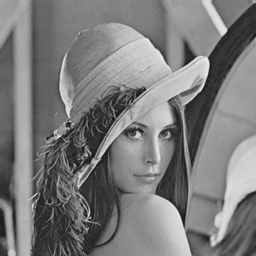

In [30]:
let image_path = Path::new(image_dir).join("Lenna.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
println!("Lenna sample is most easy to recognize rather than other sample images in Log-Polar method. if there is alternative image for Log-Polar sample, please pull request to this repository.");
opencv_imshow(&img)

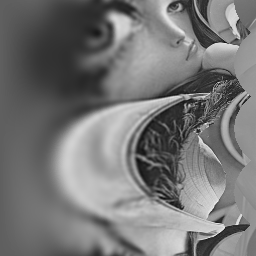

In [31]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

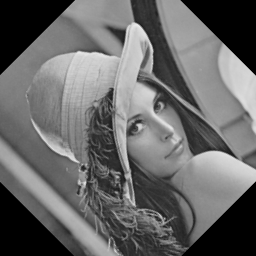

In [32]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    45.0, // angle
    1.0 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_trans_dst)

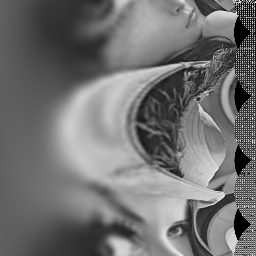

In [33]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img_trans_dst,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

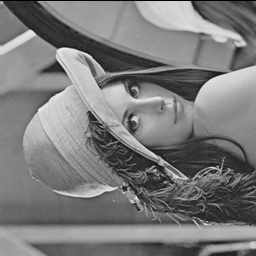

In [34]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    90.0, // angle
    1.0 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_trans_dst)

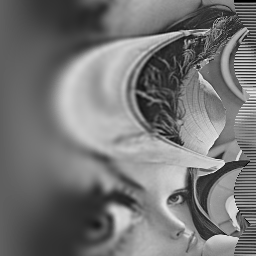

In [35]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img_trans_dst,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

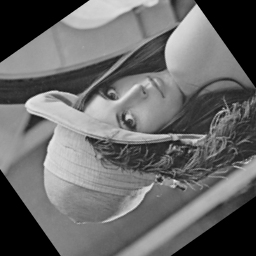

In [36]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    125.0, // angle
    1.0 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_trans_dst)

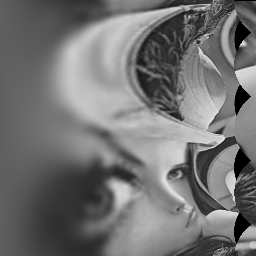

In [37]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img_trans_dst,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

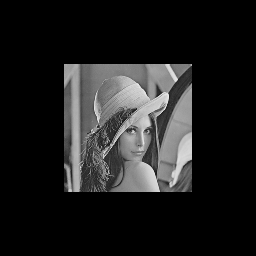

In [38]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    0.0, // angle
    0.5 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_trans_dst)

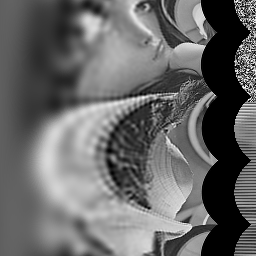

In [39]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img_trans_dst,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

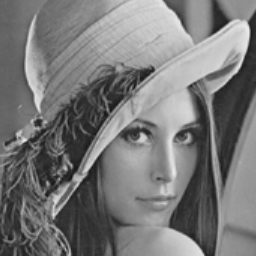

In [40]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    0.0, // angle
    1.5 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_trans_dst)

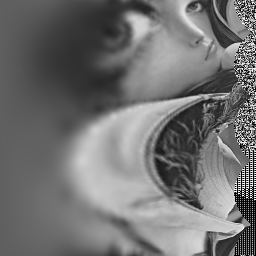

In [41]:
let mut img_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &img_trans_dst,
    &mut img_warp_dst,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::core::Point2f::new(128., 128.),
    img.rows() as f64 * 0.8, // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
opencv_imshow(&img_warp_dst)

# Rotation Invariant Phase Only Correlation

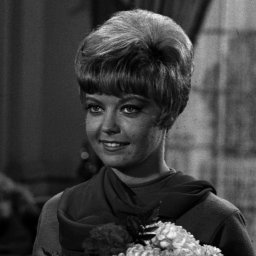

In [54]:
let image_path = Path::new(image_dir).join("Girl.bmp");
let img: Mat = opencv::imgcodecs::imread(image_path.to_str().unwrap(), opencv::imgcodecs::IMREAD_GRAYSCALE)?;
let mut img_f32: Mat = Default::default();
img.convert_to(&mut img_f32, opencv::core::CV_32FC1, 1., 0.);
opencv_imshow(&img_f32)

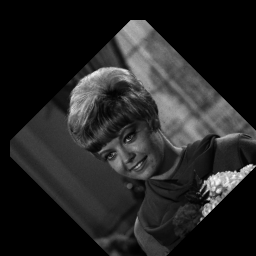

In [55]:
let trans: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(128., 128.), //center
    45.0, // angle
    0.75 // scale
).unwrap();
let mut img_trans_dst: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img_f32,
    &mut img_trans_dst,
    &trans,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);

let mut temp: Mat = Default::default();
let shift: Mat = Mat::from_slice_2d(&[[1. as f32, 0., 10.], [0., 1., 20.]]).unwrap();
img_trans_dst.copy_to(&mut temp);
opencv::imgproc::warp_affine(
    &temp,
    &mut img_trans_dst,
    &shift,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);

opencv_imshow(&img_trans_dst)

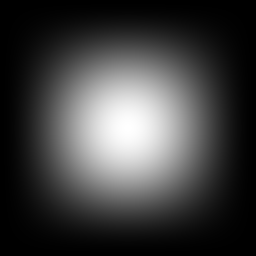

In [56]:
let h: i32 = img_f32.rows();
let w: i32 = img_f32.cols();
let mut hy: Mat = Default::default();
let mut hx: Mat = Default::default();
opencv::imgproc::create_hanning_window(
    &mut hy,
    opencv::core::Size::new(h, h),
    opencv::core::CV_32F);
opencv::imgproc::create_hanning_window(
    &mut hx,
    opencv::core::Size::new(w, w),
    opencv::core::CV_32F);
let mut hw: Mat = Default::default();
opencv::core::multiply(
    &hy.reshape(1, h).unwrap(),
    &hx,
    &mut hw,
    1.,
    -1
).unwrap();
opencv_imshow(&hw)

In [57]:
fn fft_visualize(target: &Mat) -> Result<Mat> {
    let mut splitted: opencv::core::Vector<Mat> = opencv::types::VectorOfMat::new();
    opencv::core::split(target, &mut splitted);
    let mut magnitude_dst: Mat = Default::default();
    opencv::core::magnitude(&splitted.get(0).unwrap(), &splitted.get(1).unwrap(), &mut magnitude_dst);
    magnitude_dst = (magnitude_dst + &opencv::core::Scalar::all(1.)).into_result().unwrap().to_mat().unwrap();
    let mut magnitude_log_dst: Mat = Default::default();
    opencv::core::log(&magnitude_dst, &mut magnitude_log_dst);
    crop_n_rearrange(&mut magnitude_log_dst);
    let mut result: Mat = Default::default();
    opencv::core::normalize(&magnitude_log_dst, &mut result, 0., 1., opencv::core::NORM_MINMAX, -1, &opencv::core::no_array());
    Ok(result)
}

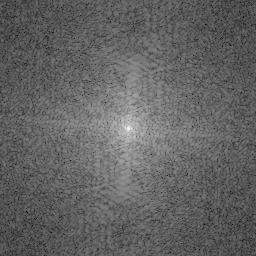

In [58]:
let mut img_multiplied: Mat = Default::default();
opencv::core::multiply(
    &img_f32,
    &hw,
    &mut img_multiplied,
    1.,
    -1
).unwrap();
let mut img_f: Mat = Default::default();
opencv::core::dft(
    &img_multiplied,
    &mut img_f,
    opencv::core::DFT_COMPLEX_OUTPUT,
    0
).unwrap();

opencv_imshow(&fft_visualize(&img_f).unwrap())

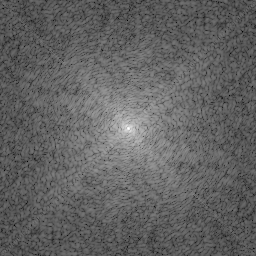

In [59]:
let mut img_trans_multiplied: Mat = Default::default();
opencv::core::multiply(
    &img_trans_dst,
    &hw,
    &mut img_trans_multiplied,
    1.,
    -1
).unwrap();
let mut img_trans_f: Mat = Default::default();
opencv::core::dft(
    &img_trans_multiplied,
    &mut img_trans_f,
    opencv::core::DFT_COMPLEX_OUTPUT,
    0
).unwrap();

opencv_imshow(&fft_visualize(&img_trans_f).unwrap())

Log-Polar image (Original)


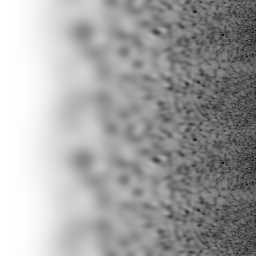

In [66]:
let mut img_f_warp_dst: Mat = Default::default();
let radius_base = (img_f.rows() as f64 * img_f.rows() as f64 + img_f.cols() as f64 * img_f.cols() as f64).sqrt();
opencv::imgproc::warp_polar(
    &fft_visualize(&img_f).unwrap(),
    &mut img_f_warp_dst,
    opencv::core::Size::new(img_f.rows(), img_f.cols()),
    opencv::core::Point2f::new(img_f.rows() as f32 / 2., img_f.cols() as f32 / 2.),
    radius_base / radius_base.ln() , // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
println!("Log-Polar image (Original)");
opencv_imshow(&img_f_warp_dst)

Log-Polar image (Transformed)


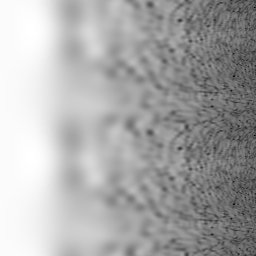

In [67]:
let mut img_trans_f_warp_dst: Mat = Default::default();
opencv::imgproc::warp_polar(
    &fft_visualize(&img_trans_f).unwrap(),
    &mut img_trans_f_warp_dst,
    opencv::core::Size::new(img_f.rows(), img_f.cols()),
    opencv::core::Point2f::new(img_f.rows() as f32 / 2., img_f.cols() as f32 / 2.),
    radius_base / radius_base.ln(), // max_radius
    opencv::imgproc::INTER_LANCZOS4 + opencv::imgproc::WARP_POLAR_LOG
);
println!("Log-Polar image (Transformed)");
opencv_imshow(&img_trans_f_warp_dst)

In [62]:
let mut spectrum_response: f64 = 0.;
let spectrum_phase_shift: opencv::core::Point2d = opencv::imgproc::phase_correlate(
    &img_f_warp_dst,
    &img_trans_f_warp_dst,
    &hw,
    &mut spectrum_response
).unwrap();
println!("Phase correlate results based on spectrum + Log-polar method.");
println!("phase_shift: {:?}, response: {}", &spectrum_phase_shift, &spectrum_response);
let spectrum_angle: f64 = (spectrum_phase_shift.y * 360.) / img.rows() as f64;
let spectrum_scale: f64 = std::f64::consts::E.powf(spectrum_phase_shift.x / (radius_base / radius_base.ln()));
println!("ange: {}, scale: {}", &spectrum_angle, &1.0 / &spectrum_scale);

Phase correlate results based on spectrum + Log-polar method.
phase_shift: Point_ { x: 16.85714038014757, y: -32.04870596801402 }, response: 0.3525701023172587
ange: -45.068492767519714, scale: 0.760081195740911


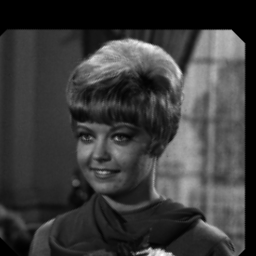

In [63]:
let trans_by_spectrum: Mat = opencv::imgproc::get_rotation_matrix_2d(
    opencv::core::Point2f::new(img.rows() as f32 / 2., img.cols() as f32 / 2.), //center
    spectrum_angle, // angle
    spectrum_scale // scale
).unwrap();
let mut img_corrected: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img_trans_dst,
    &mut img_corrected,
    &trans_by_spectrum,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_corrected)

Phase correlate results based on original image and corrected image by spectrum + Log-polar method.
phase_shift: Point_ { x: -9.812312104244228, y: 28.39377751645594 }
We don't need to calculate any angle and scale anymore. so, we just add shift.x and shift.y for shifting image.


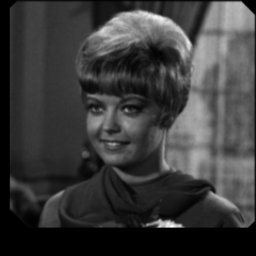

In [64]:
println!("Phase correlate results based on original image and corrected image by spectrum + Log-polar method.");
let img_phase_shift: opencv::core::Point2d = opencv::imgproc::phase_correlate(
    &img_f32,
    &img_corrected,
    &opencv::core::no_array(),
    &mut 0.
).unwrap();
println!("phase_shift: {:?}", &img_phase_shift);
println!("We don't need to calculate any angle and scale anymore. so, we just add shift.x and shift.y for shifting image.");
let shift: Mat = Mat::from_slice_2d(&[[1. , 0., -img_phase_shift.x], [0., 1., -img_phase_shift.y]]).unwrap();
let mut img_corrected_final: Mat = Default::default();
opencv::imgproc::warp_affine(
    &img_corrected,
    &mut img_corrected_final,
    &shift,
    opencv::core::Size::new(img.rows(), img.cols()),
    opencv::imgproc::INTER_LINEAR,
    opencv::core::BORDER_CONSTANT,
    opencv::core::Scalar::all(0.)
);
opencv_imshow(&img_corrected_final)

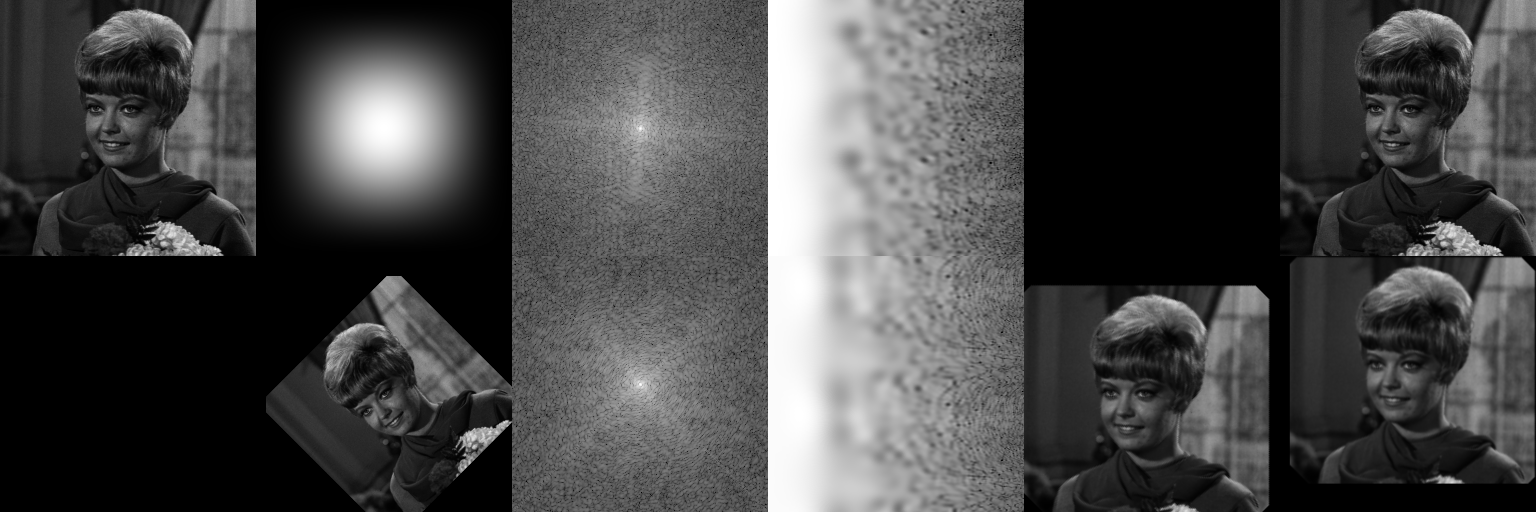

In [68]:
let mut padding: Mat = Mat::new_rows_cols_with_default(
    img_f32.rows(),
    img_f32.cols(),
    opencv::core::CV_32FC1,
    opencv::core::Scalar::all(0.)
).unwrap();

let mut hw_viz: Mat = Default::default();
to_8u_img_est(&hw).unwrap().convert_to(&mut hw_viz, opencv::core::CV_32FC1, 1., 0.);
let mut fft_orig_viz: Mat = Default::default();
to_8u_img_est(&fft_visualize(&img_f).unwrap()).unwrap().convert_to(&mut fft_orig_viz, opencv::core::CV_32FC1, 1., 0.);
let mut img_f_warp_viz: Mat = Default::default();
to_8u_img_est(&img_f_warp_dst).unwrap().convert_to(&mut img_f_warp_viz, opencv::core::CV_32FC1, 1., 0.);

let mut results_orig: opencv::core::Vector<Mat> = Default::default();
results_orig.push(Mat::copy(&img_f32).unwrap());
results_orig.push(Mat::copy(&hw_viz).unwrap());
results_orig.push(Mat::copy(&fft_orig_viz).unwrap());
results_orig.push(Mat::copy(&img_f_warp_viz).unwrap());
results_orig.push(Mat::copy(&padding).unwrap());
results_orig.push(Mat::copy(&img_f32).unwrap());

let mut fft_trans_viz: Mat = Default::default();
to_8u_img_est(&fft_visualize(&img_trans_f).unwrap()).unwrap().convert_to(&mut fft_trans_viz, opencv::core::CV_32FC1, 1., 0.);
let mut img_trans_f_warp_viz: Mat = Default::default();
to_8u_img_est(&img_trans_f_warp_dst).unwrap().convert_to(&mut img_trans_f_warp_viz, opencv::core::CV_32FC1, 1., 0.);

let mut results_trans: opencv::core::Vector<Mat> = Default::default();
results_trans.push(Mat::copy(&padding).unwrap());
results_trans.push(Mat::copy(&img_trans_dst).unwrap());
results_trans.push(Mat::copy(&fft_trans_viz).unwrap());
results_trans.push(Mat::copy(&img_trans_f_warp_viz).unwrap());
results_trans.push(Mat::copy(&img_corrected).unwrap());
results_trans.push(Mat::copy(&img_corrected_final).unwrap());

let mut results_orig_dest: Mat = Default::default();
let mut results_trans_dest: Mat = Default::default();
opencv::core::hconcat(&results_orig, &mut results_orig_dest).expect("error on concat");
opencv::core::hconcat(&results_trans, &mut results_trans_dest).expect("error on concat");
let mut results_final: Mat = Default::default();
opencv::core::vconcat2(&results_orig_dest, &results_trans_dest, &mut results_final).unwrap();
opencv_imshow(&results_final);